### Kaggle | Give Me Some Credit - Yijun ZHOU

https://www.kaggle.com/c/GiveMeSomeCredit

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import xgboost as xgb 

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [58]:
data_train = pd.read_csv("cs-training.csv").drop(columns = ["Unnamed: 0"])
data_test = pd.read_csv("cs-test.csv").drop(columns = ["Unnamed: 0"])

### Data Pre-processing

In [59]:
data_train.fillna(0, inplace = True)

In [60]:
data_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,5.348139e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.315206e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,1.550000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,4.357500e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


/Users/larcuser/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DebtRatio'>

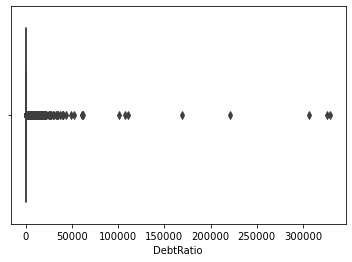

In [61]:
sns.boxplot(data_train['DebtRatio'])

In [63]:
#Outliers removal

data_train2 = data_train[data_train.DebtRatio <= 50000]
data_train2.shape

(149988, 11)

In [64]:
features = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

X = data_train2[features].to_numpy()
y = data_train2[['SeriousDlqin2yrs']].to_numpy()

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 2021, stratify = y)

In [65]:
x_test = data_test[features].fillna(0).to_numpy()

In [66]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)

x_val = sc.transform(x_val)
x_test = sc.transform(x_test)

### XGboosting

In [52]:
xgb_param_grid={'objective':['binary:logistic'], 'learning_rate': [0.05,0.1,0.2,0.25,0.3], 'max_depth': [4,5,6], 'min_child_weight': [1,2,3], 'subsample': [0.8], 'colsample_bytree': [0.7,0.9], 'n_estimators': [100,200]}

grid = RandomizedSearchCV(estimator = xgb.XGBClassifier(random_state = 2021), cv = 10, param_distributions = xgb_param_grid , scoring = 'roc_auc', verbose = 1, n_jobs = -1, refit = True) 
grid.fit(x_train,y_train)

print("Best Score:" + str(grid.best_score_)) 
print("Best Parameters: " + str(grid.best_params_)) 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.7min finished
/Users/larcuser/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/larcuser/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[15:37:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Score:0.8655736327119227
Best Parameters: {'subsample': 0.8, 'objective': 'binary:logistic', 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [53]:
best_parameters = grid.best_params_ 
xgb_model = xgb.XGBClassifier(**best_parameters)
xgb_model.fit(x_train,y_train)

[15:38:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Evaluation on The Validation Set

In [54]:
y_pred_val = xgb_model.predict_proba(x_val)[:,1]

print('ROC AUC Score:',roc_auc_score(y_val,y_pred_val))

ROC AUC Score: 0.8826


In [82]:
y_pred_val_class = xgb_model.predict(x_val)
print(classification_report(y_val,y_pred_val_class)) 

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     13996
           1       0.59      0.19      0.28      1003

    accuracy                           0.94     14999
   macro avg       0.77      0.59      0.63     14999
weighted avg       0.92      0.94      0.92     14999



### Final Prediction of The Test Set

In [56]:
y_pred = xgb_model.predict_proba(x_test)[:,1]
y_pred

array([0.06962506, 0.04847907, 0.01471899, ..., 0.0050044 , 0.063306  ,
       0.04150425], dtype=float32)

In [72]:
submission = pd.DataFrame(y_pred, columns = ['Probability'])
submission["Id"] = submission.index + 1
submission = submission[["Id", "Probability"]]

submission.to_csv("submission_xgb3.csv", index = False)